# Deep-TDA: Deep Targeted Discriminant Analysis
Reference papers: 
- *Deep-TDA*: _Trizio and Parrinello, [JPCL](https://pubs.acs.org/doi/full/10.1021/acs.jpclett.1c02317) (2021)_ [[arXiv]](https://128.84.4.34/abs/2107.05444).
- *TPI-Deep-TDA*: _Ray, Trizio and Parrinello, [JCP](https://pubs.aip.org/aip/jcp/article/158/20/204102/2891484) (2023)_ [[arXiv]](https://arxiv.org/abs/2303.01629).

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/luigibonati/mlcolvar/blob/main/docs/notebooks/tutorials/cvs_DeepTDA.ipynb)

## Introduction

The Deep Targeted Discriminant Analysis (DeepTDA) is a method for the supervised learning of discriminant-based collective variables (CVs) starting from information limited to the $N_s$ metastable states only.

In DeepTDA a Neural Network (NN) is used to map a high-dimensional set of descriptors $\mathbf{d}$, collected in the metastable states, into a low-dimensional CV space $\mathbf{s}$. The NN is trained so that the data from each metastable state, when projected along the CV, are distributed according to a preassigned target in which the different states are well-defined. In the practice, this target is taken as a sum of $N_s$ Gaussians, one for each state in the system.

<center><img src="images/deepTDAscheme.png" width="500" /></center>

The extension to the multi-case scenario is straightforward with DeepTDA. In general, given $N_s$ states, on needs to define $(N_s -1)$ CVs to fully account for all the possible transitions between them. In DeepTDA these CVs are built imposing a target that is a linear superimposition of $N_s$ multivariate Gaussians with diagonal covariances.

However, it often happens that the number of CVs can be reduced if the different states can only be visited in a precise order, i.e. in chemical reactions with stable intermidiates or with alternative and exclusive products from the same reagents. In this scenario DeepTDA allows to built one-dimensional CVs by simply imposing a target in which the ordering of the states is respected.

**Optimization criterion**

Each state $k$ thus contributes two terms for each dimension $\rho$ of the CVs space $\mathbf{s}$ to the loss function which has to be minimized during the training of the model. 

$$L^\mu_{k,\rho} = (\mu_{k,\rho} - \mu^{tg}_{k,\rho})^2 \qquad L^\sigma_{k,\rho} = (\sigma_{k,\rho} - \sigma^{tg}_{k,\rho})^2$$

The term $L^\mu_{k,\rho}$ enfroces the position of the center $\mu$ of the distribution of data from state $k$ along the dimension $\rho$ to match the target one $\mu^tg$. The second term $L^\sigma_{k,\rho}$ does the same thing for the width of the distribution, defined as the standard deviation.

The total loss function is obtained by summing over the $N_s$ states $k$ and the $N_d$ dimension $\rho$ of the CVs space:

$$ L_{TDA} = \sum_\rho^{N_d} \sum_k^{N_s} [\alpha L^\mu_{k,\rho} + \beta L^\sigma_{k,\rho}] $$ 

Where $\alpha$ and $\beta$ hyperparameters are used to balance the center and width contributions to the loss to roughly the same magnitude in the first stage of the training.

**Choice of the target**

**_Fast most-of-the-times recipe_**:
- `target_centers` : The Gaussians associated to different metastable states should be placed in a way such that the distance with respect to other Gaussians is at least around 10/20 au. *For example* $\mu_A =-7, \mu_B=7$  
- `target_sigmas` : Widths of the order of 0.2/0.5 should be fine most of the time.

**_Rationale behind_** :
In order to get an effective DeepTDA CV the Gaussians associated to the different states must be:
- **Not too close to each other** otherwise the there would not be enough space in between for the transition state (on which typically one has very limited information)
- **Not too far each other** otherwise most of the CV space would require the NN to extrapolate rather than to interpolate from the provided data.
- **Not too narrow**, besides being unphysical this would also lead to a very strong dependence on the atomic positions, which is better to be avoided in a biasing context as it would result in very strong forces
- **Not too wide**, besides being unphysical this would also lead to a very weak dependence on the atomic positions, which is better to be avoided in a biasing context as it would result in very small forces

## TPI-Deep-TDA

A further improvement over Deep-TDA is its Transition Path Informed (TPI) version. This method allows to refine in a second moment a Deep-TDA CV by including in the training set also data from the Transition Path Ensemble (TPE) and treating them as a separate class (see the workflow below for a two state system). This in general both improves and speeds up the convergence of the simulations as it provides to the model also information between the metastable states.

<center><img src="images/TPI_deepTDA.png" width="800" /></center>

In the practice, the TPE data are collected by trimming reactive trajectories which can be easily generated with the OPES-Flooding biasing scheme using a standard Deep-TDA CV. However, in principle, similar results could be achieved with different techniques (high T, metadynamics, Gambes..).
The TPE is added to the Deep-TDA CV as a broader ($\sigma_{TPE}$ =  1.0/2.0) state between the metastable ones, still ensuring a negligible overlap with them.



## Setup

In [1]:
# Colab setup
import os

if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh TUTORIAL', shell=True, stdout=subprocess.PIPE)
    print(cmd.stdout.decode('utf-8'))

# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt

# IMPORT HELPER FUNCTIONS
from mlcolvar.utils.plot import muller_brown_potential, plot_isolines_2D, plot_metrics

# Set seed for reproducibility
torch.manual_seed(42)

/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Two states case


### Load MD data
We will use the two-state Muller-Brown potential as first example using `p.x` and `p.y` as descriptors.
To easily create a dataset we can use the util `create_dataset_from_files` and from that we initilize the lightning `DictModule` for the training.

In [2]:
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictModule

n_states = 2
filenames = [ f"data/muller-brown/unbiased/state-{i}/COLVAR" for i in range(n_states) ]

# load dataset
dataset, df = create_dataset_from_files(filenames,return_dataframe=True, filter_args={'regex':'p.x|p.y'})

# create datamodule for trainere
datamodule = DictModule(dataset,lengths=[0.8,0.2])
datamodule

Class 0 dataframe shape:  (2001, 13)
Class 1 dataframe shape:  (2001, 13)

 - Loaded dataframe (4002, 13): ['time', 'p.x', 'p.y', 'p.z', 'ene', 'pot.bias', 'pot.ene_bias', 'lwall.bias', 'lwall.force2', 'uwall.bias', 'uwall.force2', 'walker', 'labels']
 - Descriptors (4002, 2): ['p.x', 'p.y']


DictModule(dataset -> DictDataset( "data": [4002, 2], "labels": [4002] ),
		     train_loader -> DictLoader(length=0.8, batch_size=0, shuffle=True),
		     valid_loader -> DictLoader(length=0.2, batch_size=0, shuffle=True))

We can use the `plot_isolines_2D` util to have a quick sketch of the Muller-Brown potential.

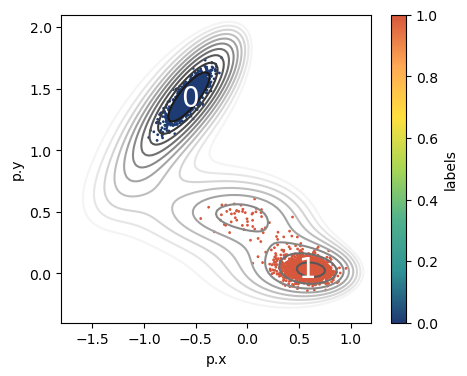

In [3]:
fig,ax = plt.subplots(figsize=(5,4),dpi=100)
# ploy MB isolines
plot_isolines_2D(muller_brown_potential,mode='contour',levels=np.linspace(0,24,12),ax=ax)
# plot points colored according to labels
df.plot.scatter('p.x','p.y',c='labels',s=1,cmap='fessa',ax=ax)
# draw state labels
for i in range(n_states):
    df_g = df.groupby('labels').mean()
    ax.text(x = df_g['p.x'].values[i]-0.075, 
            y = df_g['p.y'].values[i]-0.075,
            s = str(i), size=20, color='white')


### Model

We import the `DeepTDA` CV class and initialize it with the target parameters. Here as target we just use two Gaussian in one dimension.

In [4]:
from mlcolvar.cvs import DeepTDA

# Parameters
n_cvs = 1
target_centers = [-7, 7]
target_sigmas = [0.2, 0.2]
nn_layers = [2,24,12,1]

# Initialize DeepTDA model
model = DeepTDA(n_states=n_states, n_cvs=1,target_centers=target_centers, target_sigmas=target_sigmas, layers=nn_layers)

We initialize the `lightining.Trainer` and `Fit` the model.

In [5]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_loss", mode='min', min_delta=1e-2, patience=20)

# define trainer
trainer = lightning.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=400, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | In sizes | Out sizes
-----------------------------------------------------------------
0 | loss_fn | TDALoss       | 0      | ?        | ?        
1 | norm_in | Normalization | 0      | [2]      | [2]      
2 | nn      | FeedForward   | 385    | [2]      | [1]      
-----------------------------------------------------------------
385       Trainable params
0         Non-trainable params
385       Total params
0.002     Total estimated model params size (MB)


/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 28.42it/s, v_num=88]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 27.02it/s, v_num=88]


Learning curve

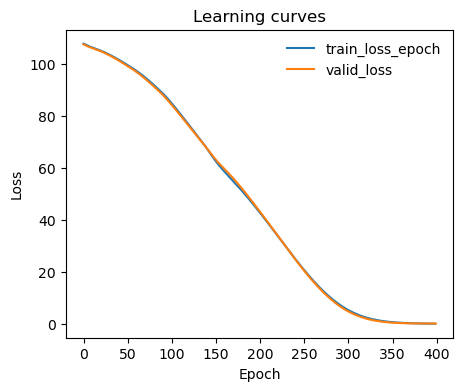

In [6]:
ax = plot_metrics(metrics.metrics, 
                  keys=['train_loss_epoch','valid_loss'],
                  #linestyles=['-.','-'], colors=['fessa1','fessa5'],
                  yscale='linear')

### Analysis of the CV

The CV isolines should follow the underlying free energy landscape.

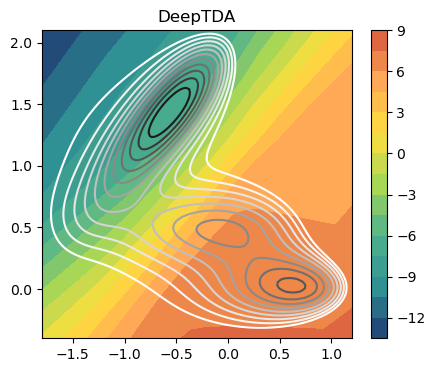

In [7]:
fig,ax = plt.subplots( 1, 1, figsize=(5,4) )

plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
plot_isolines_2D(model, levels=15, ax=ax)
ax.set_title('DeepTDA')
plt.show()

The histogram of the training points along the CV should match the target distribution.

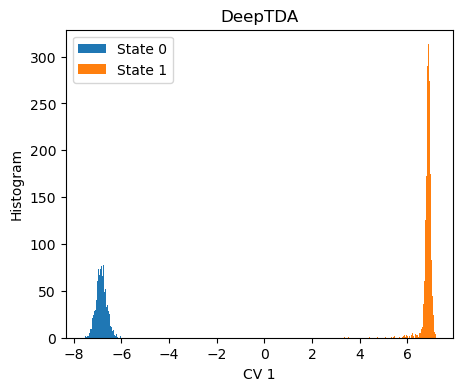

In [8]:
fig,ax = plt.subplots( 1, 1, figsize=(5,4) )

X = dataset[:]['data']
Y = dataset[:]['labels']

with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

for i in range(n_states):
    s_red = s[torch.nonzero(Y==i, as_tuple=True)]
    ax.hist(s_red[:,0],bins=100, label=f'State {i}')

ax.set_xlabel(f'CV {i}')
ax.set_ylabel('Histogram')
ax.set_title('DeepTDA')
plt.legend()
plt.show()

## Multi-state case
We first start from the general approch ($N_{d} = N_s - 1$), training a two-dimensional DeepTDA CV for a $N_s=3$ states system.

### Load MD data
We will use a modified three-state Muller-Brown potential as multi-state example using `p.x` and `p.y` as descriptors.

In [9]:
n_states = 3
filenames = [ f"data/muller-brown-3states/unbiased/state-{i}/COLVAR" for i in range(n_states) ]

# load dataset
dataset, df = create_dataset_from_files(filenames,return_dataframe=True, filter_args={'regex':'p.x|p.y'})

# create datamodule for trainere
datamodule = DictModule(dataset,lengths=[0.8,0.2])
datamodule

Class 0 dataframe shape:  (2001, 13)
Class 1 dataframe shape:  (2001, 13)
Class 2 dataframe shape:  (2001, 13)

 - Loaded dataframe (6003, 13): ['time', 'p.x', 'p.y', 'p.z', 'ene', 'pot.bias', 'pot.ene_bias', 'lwall.bias', 'lwall.force2', 'uwall.bias', 'uwall.force2', 'walker', 'labels']
 - Descriptors (6003, 2): ['p.x', 'p.y']


DictModule(dataset -> DictDataset( "data": [6003, 2], "labels": [6003] ),
		     train_loader -> DictLoader(length=0.8, batch_size=0, shuffle=True),
		     valid_loader -> DictLoader(length=0.2, batch_size=0, shuffle=True))

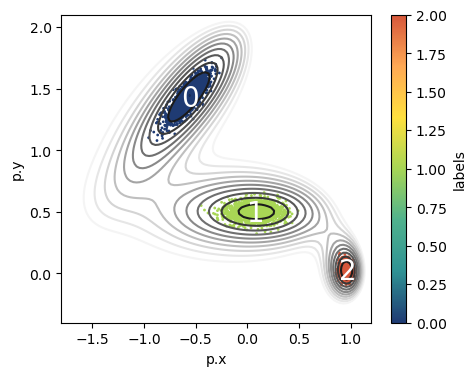

In [10]:
from mlcolvar.utils.plot import muller_brown_potential_three_states

fig,ax = plt.subplots(figsize=(5,4),dpi=100)
# ploy MB isolines
plot_isolines_2D(muller_brown_potential_three_states,mode='contour',levels=np.linspace(0,24,12),ax=ax)
# plot points colored according to labels
df.plot.scatter('p.x','p.y',c='labels',s=1,cmap='fessa',ax=ax)
# draw state labels
for i in range(n_states):
    df_g = df.groupby('labels').mean()
    ax.text(x = df_g['p.x'].values[i]-0.075, 
            y = df_g['p.y'].values[i]-0.075,
            s = str(i), size=20, color='white')


### Model
The same rules of thumb for the choice of the target can be applied also in the multi-dimensional CVs space.
For the sake of simplicity we will place the three states at the verteces of an equilateral triangle. 

In [11]:
n_cvs = 2
# The targets should be two-dimensional
target_centers = [[-4, -5], # state 0 [cv_0.mu, cv_1.mu]
                  [ 0,  5],
                  [ 4, -5]]
target_sigmas = [[0.2, 0.2], # state 0 [cv_0.sigma, cv_1.sigma]
                 [0.2, 0.2], 
                 [0.2, 0.2]]
nn_layers = [2,24,12,2]

# MODEL
model = DeepTDA(n_states=n_states, 
                n_cvs=2,
                target_centers=target_centers, 
                target_sigmas=target_sigmas,
                layers=nn_layers)

We initialize the `lightining.Trainer` and `Fit` the model.

In [12]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="train_loss", mode='min', min_delta=1e-1, patience=20)

# define trainer
trainer = lightning.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=500, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | In sizes | Out sizes
-----------------------------------------------------------------
0 | loss_fn | TDALoss       | 0      | ?        | ?        
1 | norm_in | Normalization | 0      | [2]      | [2]      
2 | nn      | FeedForward   | 398    | [2]      | [2]      
-----------------------------------------------------------------
398       Trainable params
0         Non-trainable params
398       Total params
0.002     Total estimated model params size (MB)


/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 26.63it/s, v_num=89]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 24.60it/s, v_num=89]


Learning curve

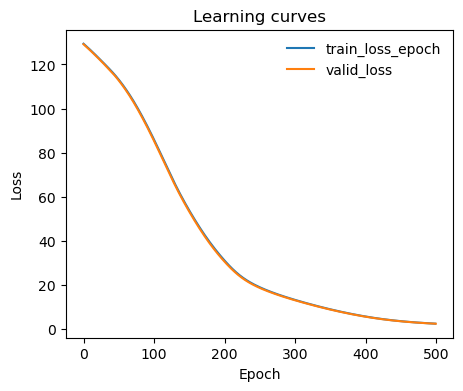

In [13]:
ax = plot_metrics(metrics.metrics, 
                  keys=['train_loss_epoch','valid_loss'],
                  #linestyles=['-.','-'], colors=['fessa1','fessa5'],
                  yscale='linear')

### Analysis of the CV

Here the two CVs isolines should give us different informations!

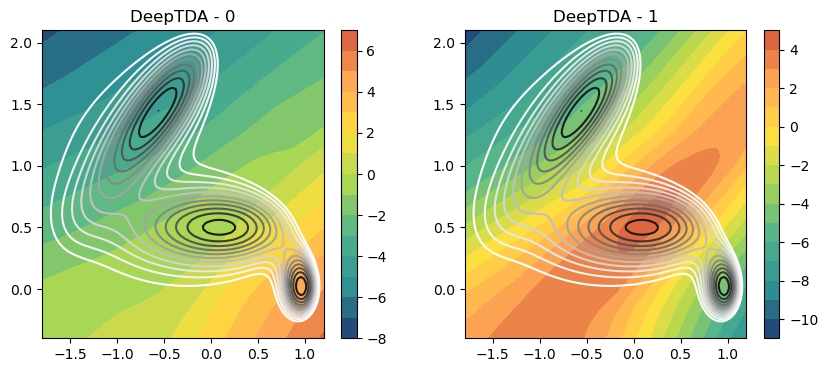

In [14]:
fig,axs = plt.subplots( 1, 2, figsize=(10,4) )
for i in range(2):
    ax = axs[i]
    plot_isolines_2D(muller_brown_potential_three_states,levels=np.linspace(0,24,12),mode='contour',ax=ax)
    plot_isolines_2D(model, component=i, levels=15, ax=ax)
    ax.set_title(f'DeepTDA - {i}')
plt.show()

The scatter plot of the training data in the CVs space should correspond to the verteces of the equilateral triangle we used as target.

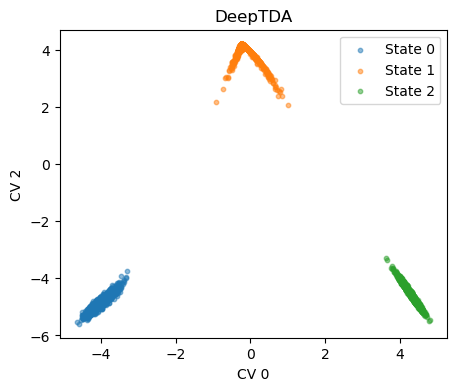

In [15]:
fig,ax = plt.subplots( 1, 1, figsize=(5,4) )

X = dataset[:]['data']
Y = dataset[:]['labels']

with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()
    
for i in range(n_states):
    s_red = s[torch.nonzero(Y==i, as_tuple=True)]
    ax.scatter(s_red[:, 0], s_red[:,1], label=f'State {i}', alpha=0.5, s=10)

ax.set_xlabel(f'CV 0')
ax.set_ylabel('CV 2')
ax.set_title('DeepTDA')
plt.legend()
plt.show()

## Multi-state reduced
We now exploit the fact that only $S_0 \leftrightarrow S_1 \leftrightarrow S_2$ transitions are allowed to reduce the dimension of the DeepTDA CVs space to $N_d = 1$ for a $N_s=3$ states system.

### Load MD data
We will use a modified three-state Muller-Brown potential as multi-state example using `p.x` and `p.y` as descriptors.

In [16]:
n_states = 3
filenames = [ f"data/muller-brown-3states/unbiased/state-{i}/COLVAR" for i in range(n_states) ]

# load dataset
dataset, df = create_dataset_from_files(filenames,return_dataframe=True, filter_args={'regex':'p.x|p.y'})

# create datamodule for trainere
datamodule = DictModule(dataset,lengths=[0.8,0.2])
datamodule

Class 0 dataframe shape:  (2001, 13)
Class 1 dataframe shape:  (2001, 13)
Class 2 dataframe shape:  (2001, 13)

 - Loaded dataframe (6003, 13): ['time', 'p.x', 'p.y', 'p.z', 'ene', 'pot.bias', 'pot.ene_bias', 'lwall.bias', 'lwall.force2', 'uwall.bias', 'uwall.force2', 'walker', 'labels']
 - Descriptors (6003, 2): ['p.x', 'p.y']


DictModule(dataset -> DictDataset( "data": [6003, 2], "labels": [6003] ),
		     train_loader -> DictLoader(length=0.8, batch_size=0, shuffle=True),
		     valid_loader -> DictLoader(length=0.2, batch_size=0, shuffle=True))

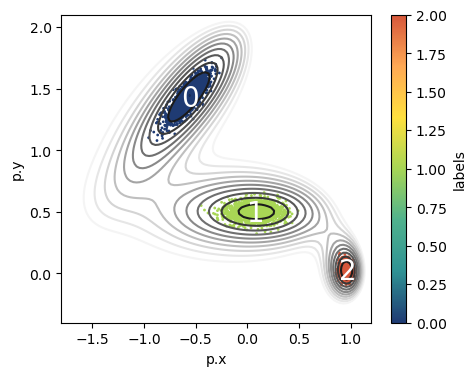

In [17]:
fig,ax = plt.subplots(figsize=(5,4),dpi=100)
# ploy MB isolines
plot_isolines_2D(muller_brown_potential_three_states,mode='contour',levels=np.linspace(0,24,12),ax=ax)
# plot points colored according to labels
df.plot.scatter('p.x','p.y',c='labels',s=1,cmap='fessa',ax=ax)
# draw state labels
for i in range(n_states):
    df_g = df.groupby('labels').mean()
    ax.text(x = df_g['p.x'].values[i]-0.075, 
            y = df_g['p.y'].values[i]-0.075,
            s = str(i), size=20, color='white')


### Model
Here we use as target a series of three consecutive Gaussians on a single CV dimension

In [18]:
n_cvs = 1
target_centers = [-14,0,14]
target_sigmas = [0.2, 0.2, 0.2]
nn_layers = [2,24,12,1]
# MODEL
model = DeepTDA(n_states=n_states, n_cvs=1,target_centers=target_centers, target_sigmas=target_sigmas, layers=nn_layers)

We initialize the `lightining.Trainer` and `Fit` the model.

In [19]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="train_loss", mode='min', min_delta=1e-2, patience=20)

# define trainer
trainer = lightning.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=600, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | In sizes | Out sizes
-----------------------------------------------------------------
0 | loss_fn | TDALoss       | 0      | ?        | ?        
1 | norm_in | Normalization | 0      | [2]      | [2]      
2 | nn      | FeedForward   | 385    | [2]      | [1]      
-----------------------------------------------------------------
385       Trainable params
0         Non-trainable params
385       Total params
0.002     Total estimated model params size (MB)


/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 26.48it/s, v_num=90]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 25.13it/s, v_num=90]


Learning curve

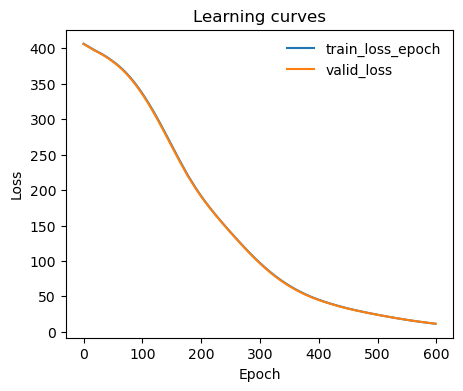

In [20]:
ax = plot_metrics(metrics.metrics, 
                  keys=['train_loss_epoch','valid_loss'],
                  #linestyles=['-.','-'], colors=['fessa1','fessa5'],
                  yscale='linear')

### Analysis of the CV

Here the isolines of a single CVs should be able to follow the free energy ladscape across all the three states

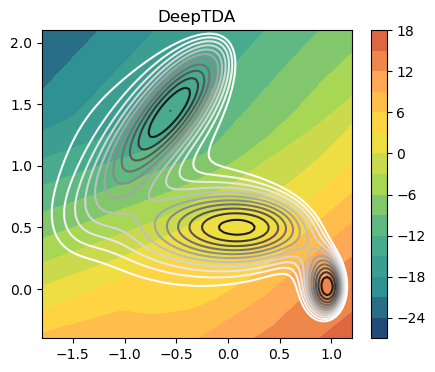

In [21]:
fig,ax = plt.subplots( 1, 1, figsize=(5,4) )

plot_isolines_2D(muller_brown_potential_three_states,levels=np.linspace(0,24,12),mode='contour',ax=ax)
plot_isolines_2D(model, levels=15, ax=ax)
ax.set_title('DeepTDA')
plt.show()

The histogram of the training data along th CVs should match the target distribution 

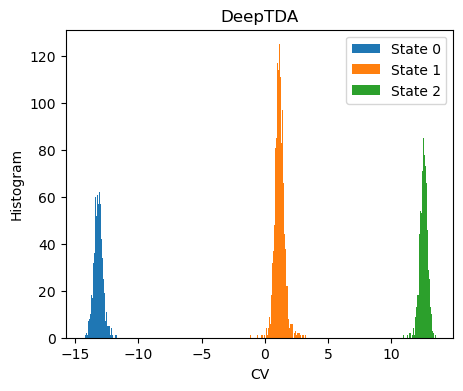

In [22]:
fig,ax = plt.subplots( 1, 1, figsize=(5,4) )

X = dataset[:]['data']
Y = dataset[:]['labels']

with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()
    
for i in range(n_states):
    s_red = s[torch.nonzero(Y==i, as_tuple=True)]
    ax.hist(s_red[:,0],bins=100, label=f'State {i}')

ax.set_xlabel(f'CV')
ax.set_ylabel('Histogram')
ax.set_title('DeepTDA')
plt.legend()
plt.show()

## TPI-Deep-TDA
We now try to refine our CV by including in the training set data from the transition path ensemble as a third state between the metastable ones.

In [23]:
from mlcolvar.utils.io import load_dataframe
data = load_dataframe('data/muller-brown/biased/flooding-tda/combined_ts.dat')

### Load data
We will use the two-state Muller-Brown potential using `p.x` and `p.y` as descriptors as an example for the application of TPI-Deep-TDA, as presented in [TPI-Deep-TDA paper](https://pubs.aip.org/aip/jcp/article/158/20/204102/2891484).

The data from the transition state region have been collected by running a series of OPES-Flooding simulations along Deep-TDA CV.

In [24]:
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictModule

filenames = [ "data/muller-brown/unbiased/state-0/COLVAR",
              "data/muller-brown/biased/flooding-tda/combined_ts.dat",
              "data/muller-brown/unbiased/state-1/COLVAR"]

n_states = len(filenames)

# load dataset
# here we only load part of the data to speed up the training, change stop to 25000 and stride to 1 to use them all for better results
dataset, df = create_dataset_from_files(filenames,
                                        create_labels=True,
                                        return_dataframe=True,
                                        filter_args={'regex':'p.x|p.y' }, # select distances between heavy atoms
                                        stop=1600,
                                        stride=1)

datamodule = DictModule(dataset,lengths=[0.8,0.2])

Class 0 dataframe shape:  (1600, 13)
Class 1 dataframe shape:  (1600, 8)
Class 2 dataframe shape:  (1600, 13)

 - Loaded dataframe (4800, 16): ['time', 'p.x', 'p.y', 'p.z', 'ene', 'pot.bias', 'pot.ene_bias', 'lwall.bias', 'lwall.force2', 'uwall.bias', 'uwall.force2', 'walker', 'labels', 'deepTDA.node-0', 'mueller', 'opes.bias']
 - Descriptors (4800, 2): ['p.x', 'p.y']


### Model
Here we use as target a series of three consecutive Gaussians, the second one will be broader as it is related to the TPE data 

In [25]:
from mlcolvar.cvs import DeepTDA

n_cvs = 1
target_centers = [-7,0,7]
target_sigmas = [0.2, 1.5, 0.2]
nn_layers = [2,24,12,1]
# MODEL
model = DeepTDA(n_states=n_states, n_cvs=1,target_centers=target_centers, target_sigmas=target_sigmas, layers=nn_layers)

We initialize the `lightining.Trainer` and `Fit` the model.

In [26]:
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()

# define trainer
# for better results we can also increase the number of epochs or use a early_stopping
trainer = lightning.Trainer(callbacks=[metrics],
                     max_epochs=500, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | In sizes | Out sizes
-----------------------------------------------------------------
0 | loss_fn | TDALoss       | 0      | ?        | ?        
1 | norm_in | Normalization | 0      | [2]      | [2]      
2 | nn      | FeedForward   | 385    | [2]      | [1]      
-----------------------------------------------------------------
385       Trainable params
0         Non-trainable params
385       Total params
0.002     Total estimated model params size (MB)


/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 24.75it/s, v_num=91]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 23.63it/s, v_num=91]


Learning curve

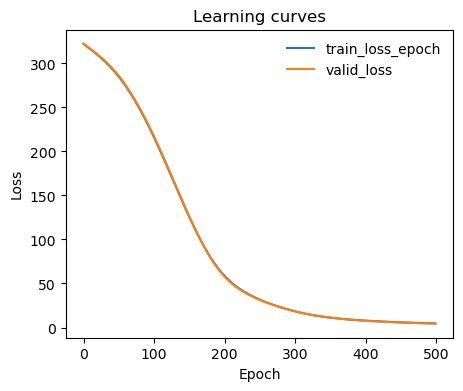

In [27]:
ax = plot_metrics(metrics.metrics, 
                  keys=['train_loss_epoch','valid_loss'],
                  #linestyles=['-.','-'], colors=['fessa1','fessa5'],
                  yscale='linear')

### Analysis of the CV

The histogram of the training data along th CVs should match the target distribution 

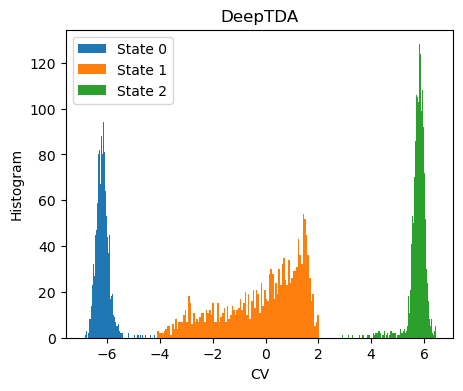

In [28]:
fig,ax = plt.subplots( 1, 1, figsize=(5,4) )

X = dataset[:]['data']
Y = dataset[:]['labels']

with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()
    
for i in range(n_states):
    s_red = s[torch.nonzero(Y==i, as_tuple=True)]
    ax.hist(s_red[:,0],bins=100, label=f'State {i}')

ax.set_xlabel(f'CV')
ax.set_ylabel('Histogram')
ax.set_title('DeepTDA')
plt.legend()
plt.show()